# Goodreads Reading List Recommender Project (Recommender)

In [1]:
# Import basic data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Use this cell to toggle between setting display.max_colwidth to None and resetting it

# Set max column width to None (no limit) so that I can see the whole text
# pd.set_option('display.max_colwidth', None)

# Reset the max column width so the pd.DataFrame is more compact
pd.reset_option('display.max_colwidth')

## Importing and Inspecting

In [3]:
# Read in the cleaned books table
books = pd.read_pickle('../Data/books.pkl')

# Look at the shape of the books table
print(books.shape)

# Look at the head of the books table
books.head(2)

(13525, 20)


,work_id,isbn,isbn13,original_title,author,original_publication_year,num_pages,description,image_url,reviews_count,text_reviews_count,5_star_ratings,4_star_ratings,3_star_ratings,2_star_ratings,1_star_ratings,ratings_count,avg_rating,avg_days_to_finish,description_clean
0,2919130,1416534601,9781416534600,Nocturnes,John Connolly,2004.0,NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,8820,338,1118,1601,1029,190,58,3996,3.9,18.0,
1,52087333,NaN,NaN,Draw Play,Tia Lewis,2016.0,NaN,Jake:\nI can't believe my coach assigned me a ...,https://s.gr-assets.com/assets/nophoto/book/11...,2482,204,204,353,274,77,29,937,3.7,4.0,jakei not believe coach assign tutor m field s...


In [4]:
# Look at the head of the engineered genres table
genres = pd.read_pickle('../Data/genres.pkl')

# Look at the shape of the genres table
print(genres.shape)

# Look at the head of the books table
genres.head(2)

(13525, 17)


,work_id,biography,children,comics,crime,fantasy,fiction,graphic,historical fiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
0,104,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0
1,114,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0


In [5]:
# Read in the similar_books table
similar_books = pd.read_pickle('../Data/similar_books.pkl')

# Look at the shape of the books table
print(similar_books.shape)

# Look at the head of the books table
similar_books.head(2)

(13525, 13525)


,104,114,115,423,434,505,696,797,817,860,...,56825332,56847346,56947505,57104739,57400201,57407230,57414860,57438069,57646853,57717521
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Recommenders

In [6]:
def get_percentiles(df, column):
    """
    Prints out seven percentiles of an input column from the input DataFrame. Specifically, the 1st, 5th, 
    25th, 50th, 75th, 95th, and 99th percentiles.
    
    Inputs:
        - df (pd.DataFrame)
        - column (str)
    Returns:
        - None
    """
    percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    for percentile in percentiles:
        print(f'{column} - {percentile} percentile: {df[column].quantile(percentile)}')

### Content-Based Filtering

From the EDA section, it was found that original_publication_year and num_pages have extreme outliers. Therefore, I will clip them before scaling to ensure accurate and balanced recommendations.

------------------------------------------------------------------------------------------------------------------------------

In [7]:
# Check the percentiles for the original_publication_year column since there are outliers
get_percentiles(books, 'original_publication_year')

original_publication_year - 0.01 percentile: 1884.06
original_publication_year - 0.05 percentile: 1967.0
original_publication_year - 0.25 percentile: 2006.0
original_publication_year - 0.5 percentile: 2011.0
original_publication_year - 0.75 percentile: 2014.0
original_publication_year - 0.95 percentile: 2016.0
original_publication_year - 0.99 percentile: 2017.0


In [8]:
# Check the percentiles for the num_pages column since there are outliers
get_percentiles(books, 'num_pages')

num_pages - 0.01 percentile: 39.94
num_pages - 0.05 percentile: 128.0
num_pages - 0.25 percentile: 260.0
num_pages - 0.5 percentile: 334.0
num_pages - 0.75 percentile: 391.0
num_pages - 0.95 percentile: 551.2999999999993
num_pages - 0.99 percentile: 792.239999999998


In [9]:
# Create clipped columns of original_publication_year and num_pages to reduce the influence of outliers
books['opy_clipped'] = books['original_publication_year'].clip(lower=books['original_publication_year'].quantile(0.05))
books['np_clipped'] = books['num_pages'].clip(upper=books['num_pages'].quantile(0.99).round())

# Fill the  missing values of the clipped columns with their respective medians of since only <1% and 5% is missing
books['np_clipped'] = books['np_clipped'].fillna(books['np_clipped'].median())
books['opy_clipped'] = books['opy_clipped'].fillna(books['opy_clipped'].median())

In [10]:
# Put the clipped original_publication_year and num_pages columns on a 0-1 scale so it matches the dummy variable scale
mms = MinMaxScaler()
books_scaled = mms.fit_transform(books[['opy_clipped', 'np_clipped']])
books = pd.concat([books, pd.DataFrame(books_scaled, columns=['opy_scaled', 'np_scaled'])], axis=1)

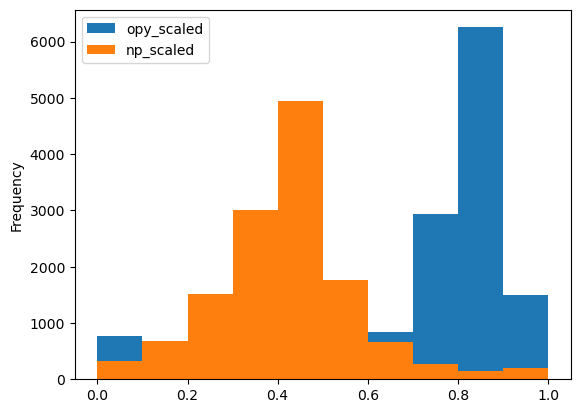

In [11]:
# Look at the distribution of the scaled and clipped columns
books[['opy_scaled', 'np_scaled']].plot.hist();

------------------------------------------------------------------------------------------------------------------------------

In [12]:
# Find out the number of different authors there are in the books table
print(f"Number of Authors: {books['author'].nunique()}")

# Find out how many authors have more than one book in the books table
print(f"Number of Multiple Publishing Authors: {sum(books['author'].value_counts() > 1)}")

# Find out how many books there are in the books table
print(f'Number of Books: {books.shape[0]}')

Number of Authors: 5554
Number of Multiple Publishing Authors: 2214
Number of Books: 13525


There are too many authors to create dummies that can be inputted into the cosine_similarity function. Therefore, instead, I plan to increase the cosine_similarity of two books by x (to be decided later) if they are written by the same author.

------------------------------------------------------------------------------------------------------------------------------

In [13]:
tv = TfidfVectorizer(stop_words='english', min_df=0.15)
tfidf = tv.fit_transform(books['description_clean'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tv.get_feature_names_out(), index=books['work_id'])

tv.get_feature_names_out()

array(['come', 'family', 'friend', 'good', 'know', 'leave', 'life',
       'like', 'live', 'love', 'man', 'new', 'secret', 'story', 'thing',
       'time', 'want', 'way', 'world', 'year', 'young'], dtype=object)

------------------------------------------------------------------------------------------------------------------------------

In [14]:
# Initialise the input matrix that will be initialised into the cosine_similarity function
model_data = genres.copy()

# Join the scaled and clipped original_publication_year and num_pages columns to X
model_data = (model_data.merge(books[['work_id', 'opy_scaled', 'np_scaled']], on='work_id')
                       .merge(tfidf_df.reset_index(), on='work_id')
             )

# Remove the work_id column from the input matrix
work_id = model_data['work_id']
model_data = model_data.drop('work_id', axis=1)

# Select columns
#X = model_data[]
#model_data

In [15]:
# Create a cosine similarity matrix that will be used for the similar books recommender 
cos_sim_matrix = cosine_similarity(model_data)

------------------------------------------------------------------------------------------------------------------------------

In [16]:
# Add a booster if the books are similar
similar_books_booster = 0.15
cos_sim_matrix = cos_sim_matrix + np.array(similar_books.replace(1, similar_books_booster))

------------------------------------------------------------------------------------------------------------------------------

In [17]:
# Get the authors series (the same order as the model_data work_id index order)
authors = pd.DataFrame(work_id).merge(books[['work_id', 'author']])
authors.index = authors['work_id']
authors = authors.drop('work_id', axis=1)

# Initialise a boost value where authors match (can be changed)
boost_value = 0.05

# Compare all pairs using broadcasting (outer comparison)
same_author_matrix = (authors['author'].values[:, None] == authors['author'].values[None, :]).astype(int)
same_author = pd.DataFrame(same_author_matrix)

# Add a booster if the books are written by the same author
same_author_booster = 0.05
cos_sim_matrix = cos_sim_matrix + np.array(same_author.replace(1, same_author_booster))

------------------------------------------------------------------------------------------------------------------------------

In [18]:
# Turn the cosine_similarity matrix into a pd.DataFrame
cos_sim = pd.DataFrame(cos_sim_matrix, columns=work_id, index=work_id)
cos_sim.columns.name = None
cos_sim.index.name = None

In [19]:
# Export the cos_sim pd.DataFrame
cos_sim.to_pickle('../Data/books_similarity_scores.pkl')

------------------------------------------------------------------------------------------------------------------------------

In [20]:
def recommendations(books_list, num_rec=5):
    # Get the work_ids of the books in the books_list
    work_ids = np.array(books[books['original_title'].isin(books_list)]['work_id'].to_list())

    # Get the average similarity_scores of the books in the book list for each book
    sim_scores = pd.DataFrame(cos_sim.loc[:, work_ids].mean(axis=1), columns=['mean_sim_score'])

    # Get all the information for each book and sort by mean_sim_score
    recommendations = (sim_scores.reset_index()
                                 .merge(books, left_on='index', right_on='work_id')
                                 .sort_values(by='mean_sim_score', ascending=False)
                      )

    # Remove books from books_list from recommendations and return num_rec rows
    recommendations = recommendations[~recommendations['work_id'].isin(work_ids)].iloc[:num_rec, 1:-5]
        
    return recommendations

In [21]:
# Initialise a list of my favourite books for quick testing
fav_books = [
    'The Silence of the Lambs', 
    'Anna Karenina', 
    'Idiot', 
    'The Catcher in the Rye', 
    'Nineteen Eighty-Four',
    'Lord of the Flies',
    'Animal Farm: A Fairy Story',
    'The Hunger Games'
]

recommendations(fav_books)

,mean_sim_score,work_id,isbn,isbn13,original_title,author,original_publication_year,num_pages,description,image_url,reviews_count,text_reviews_count,5_star_ratings,4_star_ratings,3_star_ratings,2_star_ratings,1_star_ratings,ratings_count,avg_rating,avg_days_to_finish
2109,0.679350,1431237,006074748X,9780060747480,Airs Above the Ground,Mary Stewart,1965.0,384.0,"Lovely Vanessa March, two years married and ve...",https://s.gr-assets.com/assets/nophoto/book/11...,6325,249,1437,1838,1082,132,15,4504,4.0,4.0
3325,0.676212,2904854,0373210345,9780373210343,Legacy,Cayla Kluver,2009.0,496.0,"I noticed his eyes. They were blue, sharp and ...",https://images.gr-assets.com/books/1301841400m...,20301,876,1747,1908,1577,591,348,6171,3.7,7.0
2718,0.675472,2162834,0061239755,9780061239755,The Explosionist,Jenny Davidson,2008.0,464.0,The Explosionist (formerly known as Dynamite N...,https://images.gr-assets.com/books/1275095053m...,2166,152,127,197,210,92,30,656,3.5,2.0
7512,0.674975,18132937,0765331969,9780765331960,A Natural History of Dragons,Marie Brennan,2013.0,334.0,Marie Brennan begins a thrilling new fantasy s...,https://images.gr-assets.com/books/1359770409m...,47851,2242,3360,5702,3513,846,241,13662,3.8,15.0
1359,0.674743,891863,0553381520,9780553381528,The Beekeeper's Apprentice,Laurie R. King,1994.0,341.0,"Long retired, Sherlock Holmes quietly pursues ...",https://s.gr-assets.com/assets/nophoto/book/11...,101752,4965,21766,20280,9620,2327,1106,55099,4.1,23.0


In [28]:
cos_sim[books.iloc[0]['work_id']]

104         0.217216
114         0.428214
115         0.290653
423         0.575219
434         0.525487
              ...   
57407230    0.940413
57414860    0.327096
57438069    0.448833
57646853    0.331456
57717521    0.811933
Name: 2919130, Length: 13525, dtype: float64